# Inputs

In [53]:
import os
import pandas as pd
import yaml
import torch
from warnings import filterwarnings
filterwarnings("ignore")

In [54]:
DATASET_PARAMS = yaml.load(open("configs/uc_infeksi/dataset.yaml"), Loader=yaml.SafeLoader)
PREPROCESSING_PARAMS = yaml.load(open("configs/uc_infeksi/preprocessing.yaml"), Loader=yaml.SafeLoader)
MODEL_NAME = yaml.load(open("configs/uc_infeksi/model.yaml"), Loader=yaml.SafeLoader)['MODEL_NAME']
MODEL_PARAMS = yaml.load(open("configs/uc_infeksi/model.yaml"), Loader=yaml.SafeLoader)[MODEL_NAME]
TRAINING_PARAMS = yaml.load(open("configs/uc_infeksi/training.yaml"), Loader=yaml.SafeLoader)

In [55]:
categories =  DATASET_PARAMS['CATEGORIES']

BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, DATASET_PARAMS['DATA_PATH'])

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [56]:
from src.utils import get_device, set_seed

set_seed(DATASET_PARAMS['SEED'])
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: cuda


# Dataset

The dataset structure must be like this:

XDL_Collitis/
├── datasets/
│   ├── uc/
│   │   ├── limuc/
│   │   │   ├── uc_1/
│   │   │   ├── uc_2/
│   │   │   └── uc_3/
│   │   ├── changsu/
│   │   │   ├── uc_1/
│   │   │   ├── uc_2/
│   │   │   └── uc_3/
│   │   └── hyperkvasir/
│   │       ├── uc_1/
│   │       ├── uc_2/
│   │       └── uc_3/
│   └── infeksi/
│       └── infeksi_non_spesifik/

In [57]:
from src.utils import split_dataset

In [58]:
train_filenames_df, val_filenames_df, test_filenames_df = split_dataset(DATASET_DIR, 
                                                                        categories, 
                                                                        DATASET_PARAMS['UC_SOURCE'], 
                                                                        shuffle=DATASET_PARAMS['IS_SHUFFLE'], 
                                                                        seed=DATASET_PARAMS['SEED'], 
                                                                        split_ratio=DATASET_PARAMS['SPLIT_RATIO'])

subdirectories: ['infeksi', 'uc']
subdirectory: infeksi
subdirectory: uc
subdirectory: infeksi\infeksi_non_spesifik
subdirectory: uc\changsu
subdirectory: uc\hyperkvasir
subdirectory: uc\limuc
subdirectory: uc\limuc_cropped
subdirectory: uc\changsu\uc_1
subdirectory: uc\changsu\uc_2
subdirectory: uc\changsu\uc_3
subdirectory: uc\hyperkvasir\uc_1
subdirectory: uc\hyperkvasir\uc_2
subdirectory: uc\hyperkvasir\uc_3
subdirectory: uc\limuc\uc_1
subdirectory: uc\limuc\uc_2
subdirectory: uc\limuc\uc_3


## Inspect dataset


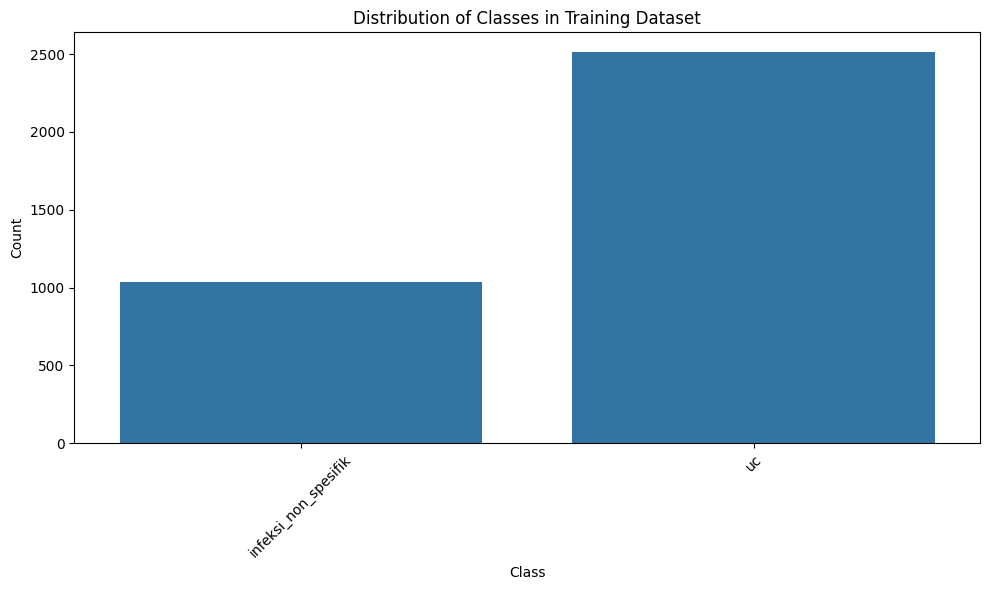

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=train_filenames_df, x='class')
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


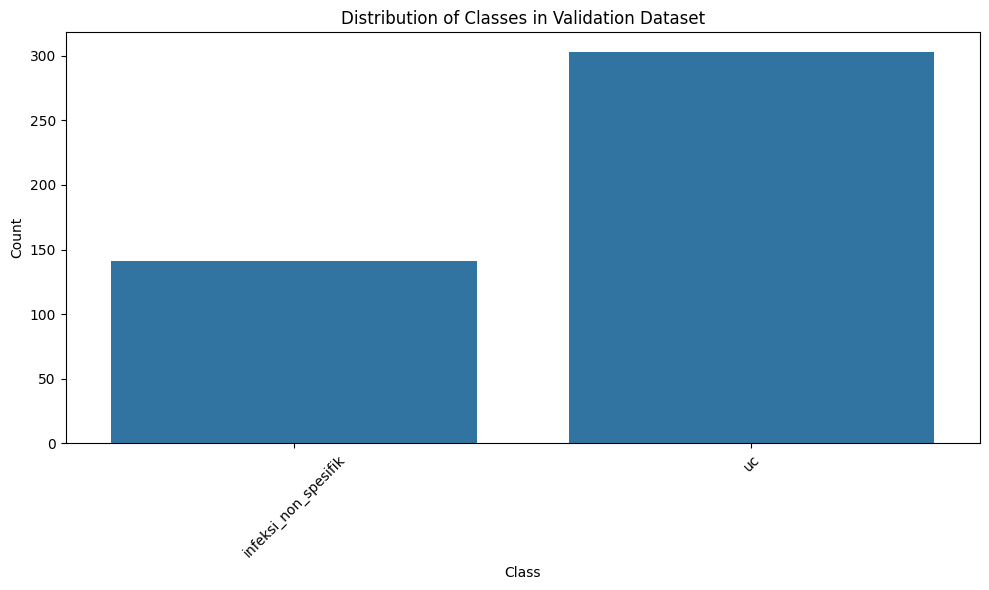

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=val_filenames_df, x='class')
plt.title('Distribution of Classes in Validation Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Pre Processor

In [61]:
from src.preprocessing import preprocess

target_input_size = tuple(PREPROCESSING_PARAMS['INPUT_SIZE'])
train_transform = preprocess(
    target_input_size=target_input_size,
    rotation_range=PREPROCESSING_PARAMS['ROTATION_RANGE'],
    width_shift_range=PREPROCESSING_PARAMS['WIDTH_SHIFT_RANGE'],
    height_shift_range=PREPROCESSING_PARAMS['HEIGHT_SHIFT_RANGE'],
    brightness_range=PREPROCESSING_PARAMS['BRIGHTNESS_RANGE'],
    zoom_range=PREPROCESSING_PARAMS['ZOOM_RANGE'],
    horizontal_flip=PREPROCESSING_PARAMS['HORIZONTAL_FLIP'],
    vertical_flip=PREPROCESSING_PARAMS['VERTICAL_FLIP'],
    channel_shift_range=PREPROCESSING_PARAMS['CHANNEL_SHIFT_RANGE'],
    fill_mode=PREPROCESSING_PARAMS['FILL_MODE'],
    shear_range=PREPROCESSING_PARAMS['SHEAR_RANGE']
    )

val_transform = preprocess(target_input_size=target_input_size) # only rescaling

In [62]:
from src.dataset import Dataset

train_dataset = Dataset(dataframe=train_filenames_df, 
                        categories=DATASET_PARAMS['CATEGORIES'],
                        transform=train_transform, 
                        seed=42, 
                        shuffle=False)

val_dataset = Dataset(dataframe=val_filenames_df, 
                      categories=DATASET_PARAMS['CATEGORIES'],
                      transform=val_transform, 
                      seed=42, 
                      shuffle=False)

test_dataset = Dataset(dataframe=test_filenames_df, 
                      categories=DATASET_PARAMS['CATEGORIES'],
                      transform=val_transform, 
                      seed=42, 
                      shuffle=False)

## Train loader

In [63]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

val_loader = DataLoader(val_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

#if test_dataset exist
if test_dataset:
    test_loader = DataLoader(test_dataset, 
                             batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                             shuffle=False, 
                             num_workers=TRAINING_PARAMS['NUM_WORKERS'])

### Inpect train data augmentation

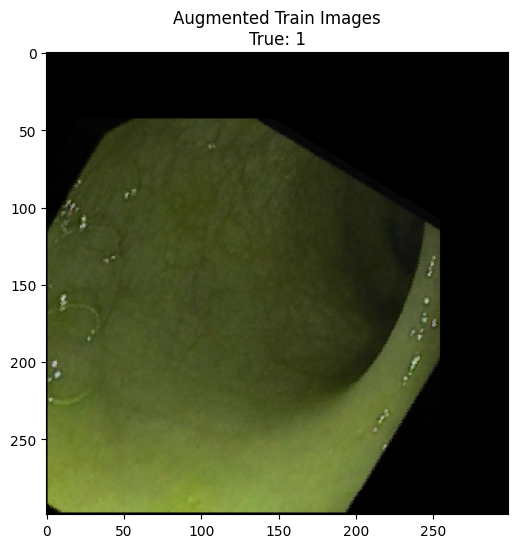

In [148]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
data, target = next(iter(train_loader))

img = data[random.randint(0, len(data) -1)].cpu().numpy()
img = np.transpose(img, (1, 2, 0))
img = img*255
plt.figure(figsize=(10, 6))
plt.title(f"Augmented Train Images\nTrue: {torch.argmax(target[random.randint(0, len(data) -1)], dim=0).item()}")
plt.imshow(img)
plt.show()

# Model

In [12]:
num_classes = len(categories)

### EfficientCapsNet

In [13]:
if MODEL_NAME == "CAPSNET":
    from src.model import EfficientCapsNet
    from src.loss import MarginLoss, marginLoss

    model = EfficientCapsNet(input_size=(MODEL_PARAMS['INPUT_SIZE']))
    loss = MarginLoss()
    # loss = marginLoss

### DenseNet

In [14]:
if MODEL_NAME == "DENSENET121":
    from src.densenet import DenseNet121
    from torch.nn import CrossEntropyLoss

    model = DenseNet121(num_classes=num_classes, dropout_rate=MODEL_PARAMS['DROPOUT_RATE'])
    loss = CrossEntropyLoss()   

# Training

## Metrics

In [15]:
# Optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=TRAINING_PARAMS['LEARNING_RATE'])

# use torcheval metrics
# metrics
from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassAUROC,
    MulticlassAUPRC,
    MulticlassRecall
)

# Metrics
from src.metrics import (
    MulticlassMCC,
    MulticlassSpecificity
)

metrics = {
    "mcc": MulticlassMCC(num_classes=num_classes, device=DEVICE),
    # "auprc": MulticlassAUPRC(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    # "auroc": MulticlassAUROC(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    "accuracy": MulticlassAccuracy(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    "f1_score": MulticlassF1Score(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    "precision": MulticlassPrecision(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE),
    "recall": MulticlassRecall(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE),
    "specificity": MulticlassSpecificity(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE)
}

In [16]:
from src.train import train

history = train(model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=loss, 
    optimizer=optimizer, 
    num_epochs=TRAINING_PARAMS['NUM_EPOCHS'], 
    device=DEVICE,
    metrics=metrics,
    print_every=TRAINING_PARAMS['PRINT_EVERY'],
    save_patience=TRAINING_PARAMS['SAVE_PATIENCE'],
    save_path=TRAINING_PARAMS['SAVE_PATH'],
    save_model=TRAINING_PARAMS['SAVE_MODEL'],
    save_metrics=TRAINING_PARAMS['SAVE_METRICS']
    )

Training...


Epochs:  20%|██        | 10/50 [42:31<2:50:06, 255.16s/it, train_loss=0.173, train_metrics=mcc: 0.8993, accuracy: 0.9499, f1_score: 0.9497, val_loss=0.192, val_metrics=mcc: 0.8619, accuracy: 0.9505, f1_score: 0.9259]


KeyboardInterrupt: 

In [19]:
import json

with open("artifacts/densenet121/training_history.json", "r") as f:
    history = json.load(f)

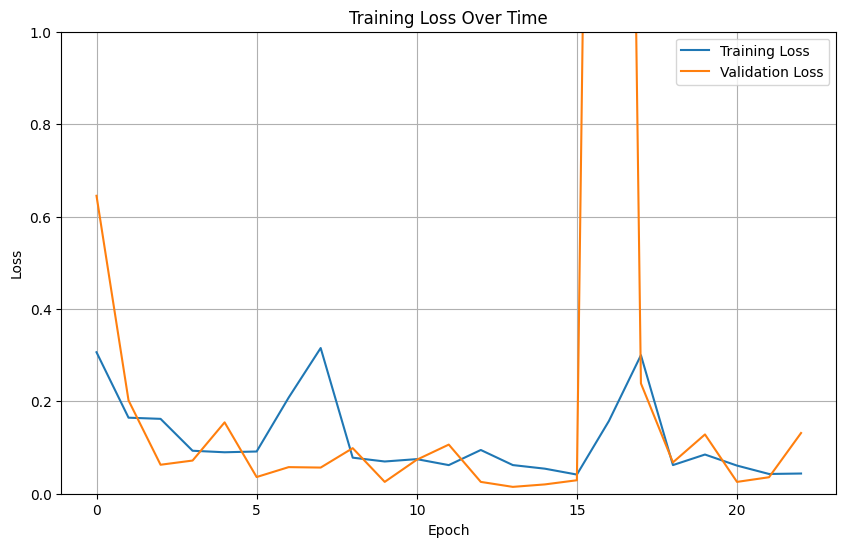

In [ ]:
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
val_loss = history["val_loss"]
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


# Test

using validation data

In [43]:
from src.utils import load_model

model = load_model("artifacts/densenet121/epoch_14.pth", num_classes=2, dropout_rate=0.25)
model = model.to(DEVICE)

In [17]:
from src.test import test

raw_predictions, predicted_indices_flattened, target_indices_flattened = test(model = model, test_loader = test_loader, device = DEVICE)

Testing: 100%|██████████| 56/56 [00:13<00:00,  4.26it/s]


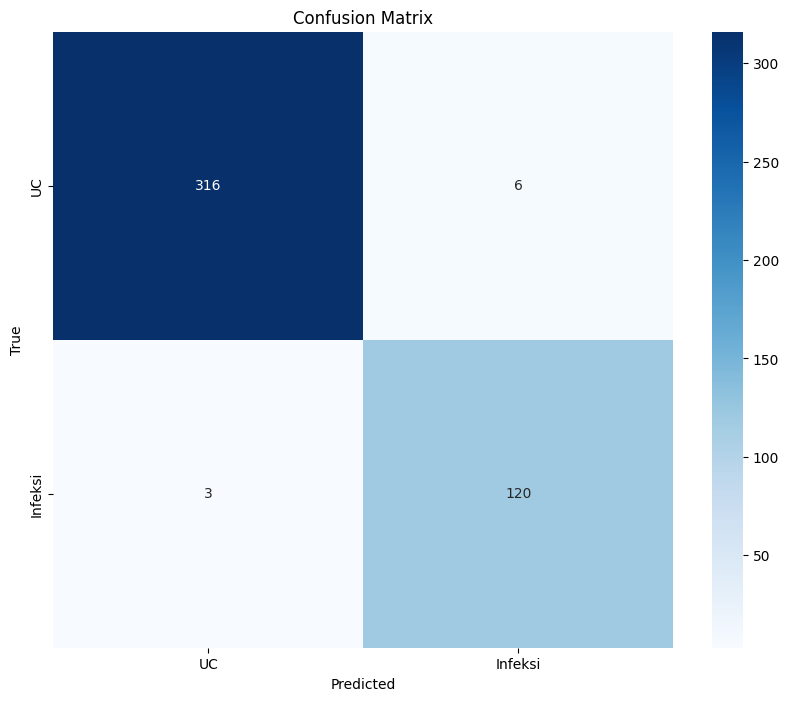

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Calculate confusion matrix
cm = confusion_matrix(target_indices_flattened, predicted_indices_flattened)

# Create figure and axis
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['UC', 'Infeksi'],
            yticklabels=['UC', 'Infeksi'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show plot
plt.show()


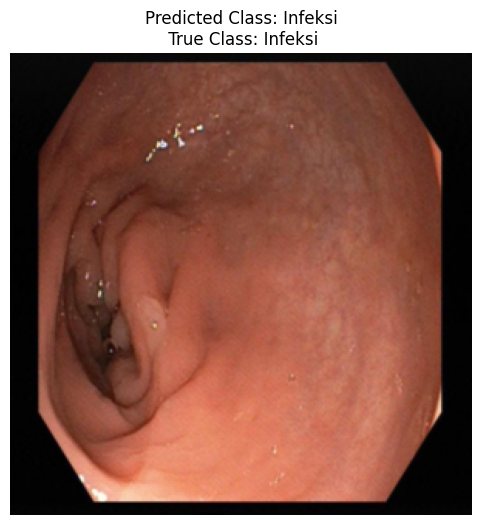

True class: Infeksi
Predicted class: Infeksi


In [19]:
sample_image, sample_target = test_dataset[1]
sample_image = sample_image.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    prediction = model(sample_image)
    predicted_class = torch.argmax(prediction, dim=1).item()

sample_image_np = sample_image.squeeze().cpu().numpy()
sample_image_np = np.transpose(sample_image_np, (1, 2, 0))
sample_image_np = sample_image_np*255
plt.figure(figsize=(8, 6))
plt.imshow(sample_image_np)
plt.title(f'Predicted Class: {"UC" if predicted_class == 0 else "Infeksi"}\n True Class: {"UC" if torch.argmax(sample_target).item() == 0 else "Infeksi"}')
plt.axis('off')
plt.show()

print(f"True class: {'UC' if torch.argmax(sample_target).item() == 0 else 'Infeksi'}")
print(f"Predicted class: {'UC' if predicted_class == 0 else 'Infeksi'}")

# XDL

In [25]:
data, target = next(iter(train_loader))
data.shape, target.shape

(torch.Size([8, 3, 299, 299]), torch.Size([8, 2]))

In [21]:
from src.xdl import plot_XDL_GradCAM

plot_XDL_GradCAM(model = model, 
                 test_loader = test_loader, 
                 device = DEVICE, 
                 print_img = True, 
                 num_samples = 100, 
                 save_path = "outputs/xdl_gradcam/limuc_cropped")

Processed 8 samples
Processed 88 samples
